## Searching for bouts for a day of alsa recording

In [1]:
%matplotlib inline
import os
import glob
import socket
import logging
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt

from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

logger.info('Running on {}'.format(socket.gethostname()))

2021-06-29 19:59:31,701 root         INFO     Running on pakhi


In [2]:
from ceciestunepipe.file import bcistructure as et

### Get the file locations for a session (day) of recordings

In [3]:
reload(et)
sess_par = {'bird': 's_b1253_21',
           'sess': '2021-06-29'}


exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='alsa')

raw_folder = exp_struct['folders']['alsa']

In [4]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-29',
 'alsa': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-29/alsa',
 'kwik': '/scratch/earneodo/s_b1253_21/alsa/kwik/2021-06-29',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-29/alsa',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-29/alsa',
 'tmp': '/scratch/earneodo/tmp',
 'msort': '/scratch/earneodo/s_b1253_21/alsa/msort/2021-06-29',
 'ksort': '/scratch/earneodo/s_b1253_21/alsa/ksort/2021-06-29'}

#### search parameters
Spectrograms are computed using librosa

Additional parameters are for bout search criteria and functions to read the data

In [5]:
# function for getting one channel out of a wave file
def read_wav_chan(wav_path: str, chan_id: int=0) -> tuple:
    s_f, x = wavfile.read(wav_path, mmap=True)
    return s_f, x[:, chan_id]

def sess_file_id(f_path):
    n = int(os.path.split(f_path)[1].split('-')[-1].split('.wav')[0])
    return n

hparams = {
    # spectrogram
    'num_freq':1024, #1024# how many channels to use in a spectrogram #
    'preemphasis':0.97, 
    'frame_shift_ms':5, # step size for fft
    'frame_length_ms':10, #128 # frame length for fft FRAME SAMPLES < NUM_FREQ!!!
    'min_level_db':-55, # minimum threshold db for computing spe 
    'ref_level_db':110, # reference db for computing spec
    'sample_rate':None, # sample rate of your data
    
    # spectrograms
    'mel_filter': False, # should a mel filter be used?
    'num_mels':1024, # how many channels to use in the mel-spectrogram
    'fmin': 500, # low frequency cutoff for mel filter
    'fmax': 12000, # high frequency cutoff for mel filter
    
    # spectrogram inversion
    'max_iters':200,
    'griffin_lim_iters':20,
    'power':1.5,

    # Added for the searching
    'read_wav_fun': read_wav_chan, # function for loading the wav_like_stream (has to returns fs, ndarray)
    'file_order_fun': sess_file_id, # function for extracting the file id within the session
    'min_segment': 30, # Minimum length of supra_threshold to consider a 'syllable' (ms)
    'min_silence': 2000, # Minmum distance between groups of syllables to consider separate bouts (ms)
    'min_bout': 5000, # min bout duration (ms)
    'peak_thresh_rms': 0.55, # threshold (rms) for peak acceptance,
    'thresh_rms': 0.25, # threshold for detection of syllables
    'mean_syl_rms_thresh': 0.3, #threshold for acceptance of mean rms across the syllable (relative to rms of the file)
    'max_bout': 120000, #exclude bouts too long
    'l_p_r_thresh': 100, # threshold for n of len_ms/peaks (typycally about 2-3 syllable spans
    
    'waveform_edges': 1000, #get number of ms before and after the edges of the bout for the waveform sample
    
    'bout_auto_file': 'bout_auto.pickle', # extension for saving the auto found files
    'bout_curated_file': 'bout_checked.pickle', #extension for manually curated files (coming soon)
    }

#### Get one wave file

In [6]:
one_wav_path = os.path.join(exp_struct['folders']['alsa'], '07-00-02-02.wav')

s_f, x = read_wav_chan(one_wav_path)

hparams['sample_rate'] = s_f

In [7]:
x.shape

(81600000,)

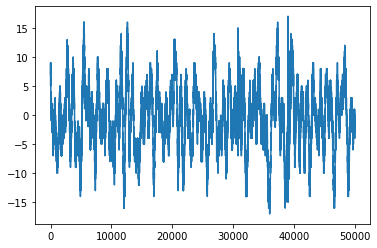

In [8]:
plt.plot(x[:50000])

### try the function to search for bouts in the file

In [9]:
from ceciestunepipe.util.sound import boutsearch as bs

In [10]:
reload(bs)

<module 'ceciestunepipe.util.sound.boutsearch' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/sound/boutsearch.py'>

In [11]:
bpd, x, p = bs.get_bouts_in_file(one_wav_path, hparams)

2021-06-29 19:59:45,764 ceciestunepipe.util.sound.boutsearch INFO     Getting bouts for file /mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-29/alsa/07-00-02-02.wav
2021-06-29 20:00:53,056 numexpr.utils INFO     Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-06-29 20:00:53,057 numexpr.utils INFO     NumExpr defaulting to 8 threads.


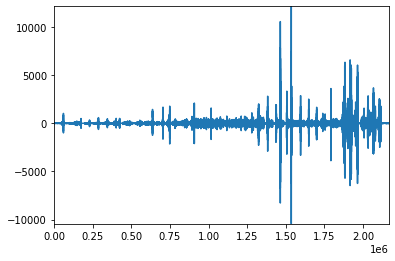

In [13]:
plt.plot(bpd['waveform'].values[0])

In [14]:
bpd

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,syl_in,n_syl,peaks_p,n_peaks,l_p_ratio,waveform
0,1374510,1417635,65976480,68046480,"[1.162909673461553, 1.9454584380127675, 1.2650...",4.257527,173.941341,True,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,43125,"[[1374510, 1374720], [1374735, 1374810], [1376...",178,"[10, 23, 41, 49, 56, 340, 348, 355, 373, 380, ...",605,71.280992,"[7, 6, 6, 5, 5, 5, 5, 5, 3, 4, 5, 3, 4, 4, 4, ..."


### inspect the bouts and curate them

#### visualize one bout

In [16]:
bpd['spectrogram'] = bpd['waveform'].apply(lambda x: bs.gimmepower(x, hparams)[2])

In [17]:
bpd.iloc[0]

start_ms                                                  1374510
end_ms                                                    1417635
start_sample                                             65976480
end_sample                                               68046480
p_step          [1.162909673461553, 1.9454584380127675, 1.2650...
rms_p                                                    4.257527
peak_p                                                 173.941341
bout_check                                                   True
file            /mnt/sphere/speech_bci/raw_data/s_b1253_21/202...
len_ms                                                      43125
syl_in          [[1374510, 1374720], [1374735, 1374810], [1376...
n_syl                                                         178
peaks_p         [10, 23, 41, 49, 56, 340, 348, 355, 373, 380, ...
n_peaks                                                       605
l_p_ratio                                               71.280992
waveform  

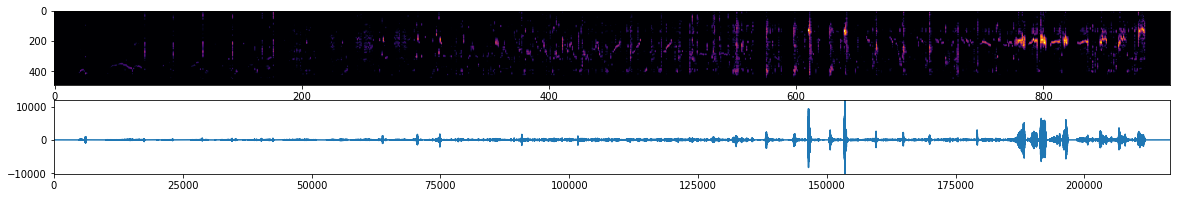

In [18]:
def viz_bout(df: pd.Series, ax_arr=None, sub_sample=10):
    # get the power and the spectrogram
    sxx = df['spectrogram'][:, ::sub_sample]
    x = df['waveform'][::sub_sample]
    
    if ax_arr is None:
        fig, ax_arr = plt.subplots(nrows=2, figsize=(20, 4))
    
    ax_arr[0].imshow((sxx[::-1]), aspect='auto', cmap='inferno')
    ax_arr[1].plot(x)
    
fig, ax = plt.subplots(nrows=2, figsize=(20, 3))

viz_bout(bpd.iloc[0], ax)

In [19]:
plt.subplots?

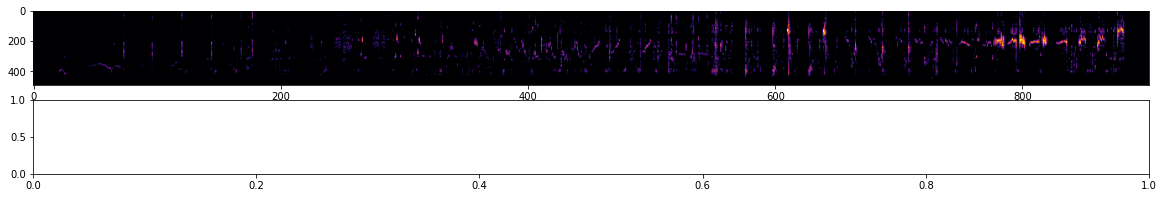

In [20]:
fig, ax_arr = plt.subplots(nrows=2, figsize=(20, 3))

sxx = bpd.iloc[0]['spectrogram'][:, ::10]
ax_arr[0].imshow(sxx[::-1], aspect='auto', cmap='inferno')

In [32]:
hparams

{'num_freq': 1024,
 'preemphasis': 0.97,
 'frame_shift_ms': 5,
 'frame_length_ms': 10,
 'min_level_db': -55,
 'ref_level_db': 110,
 'sample_rate': 48000,
 'mel_filter': False,
 'num_mels': 1024,
 'fmin': 500,
 'fmax': 12000,
 'max_iters': 200,
 'griffin_lim_iters': 20,
 'power': 1.5,
 'read_wav_fun': <function __main__.read_wav_chan(wav_path: str, chan_id: int = 0) -> tuple>,
 'file_order_fun': <function __main__.sess_file_id(f_path)>,
 'min_segment': 30,
 'min_silence': 2000,
 'min_bout': 5000,
 'peak_thresh_rms': 0.55,
 'thresh_rms': 0.25,
 'mean_syl_rms_thresh': 0.3,
 'max_bout': 120000,
 'l_p_r_thresh': 100,
 'bout_auto_file': 'bout_auto.pickle',
 'bout_curated_file': 'bout_checked.pickle'}